In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
from statsmodels.stats.anova import AnovaRM
from sklearn.metrics import precision_recall_fscore_support

In [8]:
root_path = os.path.abspath(os.path.join('..', '..'))

In [9]:
# Method used for getting the right path for a model based on the device name and the cv number
'''
root_path: the root path of the project
device: the device name
cv: the cross validation number

Acceptable model types: attend, deepconv, tinyhar
'''


def get_model_path(root_path, device, model_type, cv):
    path = root_path
    parent_path = os.path.join(path, 'data', 'Run_logs', device, 'logs')
    # parent paths has three folders for attend, deepCONV, TinyHAR. Get a list of all folders in the parent path
    folders = os.listdir(parent_path)
    for folder in folders:
        if model_type in folder:
            path = os.path.join(parent_path, folder)
            break
    # path now has the path to the model type folder
    path = os.path.join(path, 'cv_' + str(cv))
    return path


def get_result_for_model(root_path, model_device, test_device, model_type, cv):
    path = get_model_path(root_path, model_device, model_type, cv)
    filename = 'prediction_result_' + model_device + '_' + test_device + '.csv'
    path = os.path.join(path, filename)
    # open the csv file prediction_result_ and read the data
    csv_file = path
    # open with pandas
    df = pd.read_csv(csv_file)
    # if the file is empty, continue
    if df.empty:
        return None

    # get the prediction result
    preds = df['preds'].values
    # get the ground truth
    trues = df['trues'].values

    # Assuming binary classification
    num_classes = 2

    # Calculate precision, recall, and f1 for each class
    precision, recall, f1, _ = precision_recall_fscore_support(trues, preds, average=None)

    # Calculate accuracy
    accuracy = np.sum(preds == trues) / len(preds)

    # Calculate macro F1
    f1_macro = np.mean(f1)

    # Calculate weighted F1
    class_distribution = np.bincount(trues)
    f1_weighted = np.sum(f1 * class_distribution / len(trues))

    # accuracy = np.sum(preds == trues) / len(preds)
    # precision = np.sum((preds == 1) & (trues == 1)) / np.sum(preds == 1)
    # recall = np.sum((preds == 1) & (trues == 1)) / np.sum(trues == 1)
    # f1 = 2 * np.sum((preds == 1) & (trues == 1)) / (np.sum(preds == 1) + np.sum(trues == 1))
    # f1_w = (precision + recall) / 2

    return accuracy, precision, recall, f1_macro, f1_weighted  #, preds, trues

## 1 v 1 Graphs and Info

          f1  cv device_config model_type
5   0.844757   0  RWR2 vs RWR1    tinyhar
11  0.454246   1  RWR2 vs RWR1    tinyhar
17  0.922616   2  RWR2 vs RWR1    tinyhar
23  0.415922   3  RWR2 vs RWR1    tinyhar
29  0.907802   4  RWR2 vs RWR1    tinyhar
35  0.987473   5  RWR2 vs RWR1    tinyhar
41  0.399053   6  RWR2 vs RWR1    tinyhar
47  0.992612   7  RWR2 vs RWR1    tinyhar


D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


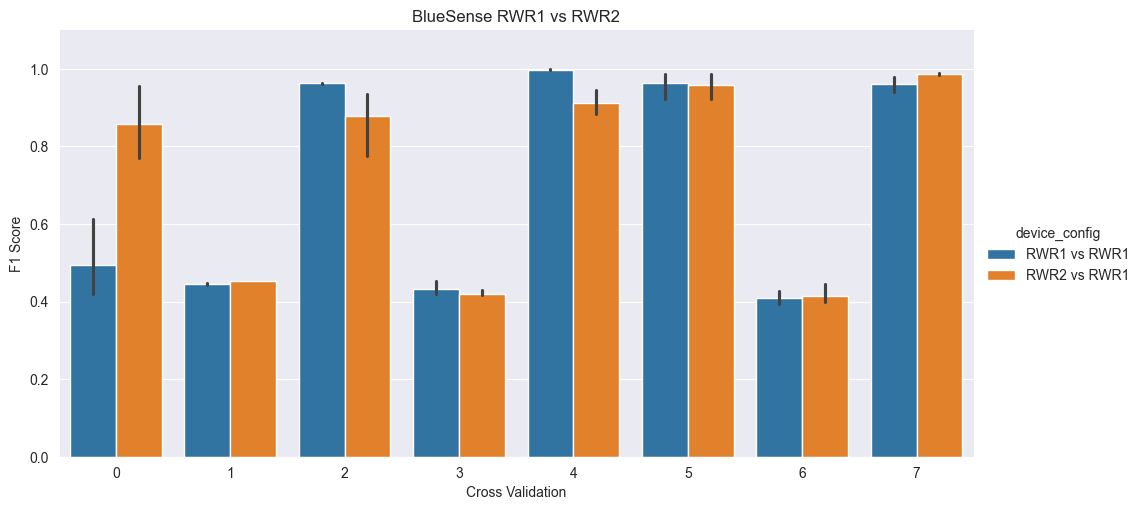

In [23]:
# Blue sense rwr1 vs rwr2
result_list = []
for i in range(8):
    for model in ['attend', 'deepconv', 'tinyhar']:
        result1 = get_result_for_model(root_path, 'bluesense-RWR2', 'bluesense-RWR1', model, i)
        result2 = get_result_for_model(root_path, 'bluesense-RWR1', 'bluesense-RWR1', model, i)
        dict_results = {'f1': result2[3],
                        'cv': i,
                        'device_config': 'RWR1 vs RWR1', 'model_type': model}
        result_list.append(dict_results)
        dict_results = {'f1': result1[3],
                        'cv': i,
                        'device_config': 'RWR2 vs RWR1', 'model_type': model}
        result_list.append(dict_results)

df = pd.DataFrame(result_list)
# print only rwr1 vs rwr1 and model deepconv
print(df[(df['device_config'] == 'RWR2 vs RWR1') & (df['model_type'] == 'tinyhar')])

# plot the f1 score for all participants as bar graph using sns catplot bar
sns.catplot(x='cv', y='f1', hue='device_config', data=df, kind='bar', aspect=2, height=5)
plt.title('BlueSense RWR1 vs RWR2')
plt.xlabel('Cross Validation')
plt.ylabel('F1 Score')
# plot max y value is 1.1
plt.ylim(0, 1.1)
plt.show()


In [11]:
# Method for creating a multi bar graph with x axis and y axis values in the for of a list
'''
x: list of x axis labels
y: list of y axis values
x_label: x axis label
y_label: y axis label
title: title of the graph
width: width of the graph
height: height of the graph
bar_width: width of each bar
'''


def generate_multi_bar_graph(data_frame, x_label, y_label, title, width, height, bar_width, std=False):
    # set the width of the bars
    bar_width = bar_width
    sns.barplot(data_frame, x=x_label, y=y_label, palette='dark', errorbar='sd' if std else None)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.ylim(0, 1)
    plt.legend(loc='upper right')
    plt.xticks(rotation=45)
    plt.gcf().set_size_inches(width, height)
    plt.show()


def get_f1_df(model_device, test_devices):
    data = {'Device': [], 'F1 Score': [], 'model_type': [], 'cv': []}
    df = pd.DataFrame(data)
    for device in test_devices:
        print(device)
        for i in range(8):
            new_row = {'Device': device,
                       'F1 Score': get_result_for_model(root_path, model_device, device, 'attend', i)[3],
                       'model_type': 'attend',
                       'cv': i}
            df = pd.concat([df, pd.DataFrame(new_row, index=[0])], ignore_index=True)
            new_row = {'Device': device,
                       'F1 Score': get_result_for_model(root_path, model_device, device, 'deepconv', i)[3],
                       'model_type': 'deepconv',
                       'cv': i}
            df = pd.concat([df, pd.DataFrame(new_row, index=[0])], ignore_index=True)
            new_row = {'Device': device,
                       'F1 Score': get_result_for_model(root_path, model_device, device, 'tinyhar', i)[3],
                       'model_type': 'tinyhar',
                       'cv': i}
            df = pd.concat([df, pd.DataFrame(new_row, index=[0])], ignore_index=True)
    return df


def generate_graph_with_std(root_path, model_device, test_devices):
    df = get_f1_df(model_device, test_devices)

    # generate the graph
    g = sns.catplot(x='Device', y='F1 Score', hue='model_type', data=df, kind='bar', palette='dark', errorbar='sd',
                    alpha=.6, height=6, aspect=2).set(title='F1 Score for Model trained with ' + model_device)
    g.despine(left=True)
    g.set_ylabels('F1 Score')
    g.set_xlabels('Device')
    g.set_xticklabels(rotation=45)

    # save the graph in folder mean_graphs in the logs, create folder if not exists
    if not os.path.exists(os.path.join(root_path, 'data', 'Run_logs', model_device, 'logs', 'mean_graphs')):
        os.makedirs(os.path.join(root_path, 'data', 'Run_logs', model_device, 'logs', 'mean_graphs'))
    # plt.savefig(os.path.join(root_path, 'data', 'Run_logs', model_device, 'logs', 'mean_graphs',
    #                          'F1 Score for Model trained with ' + model_device + '.png'))




In [12]:
test_devices = ['bluesense-RWR1', 'bluesense-RWR2', 'bluesense-LWR', 'bluesense-LUA', 'bluesense-RUA', 'bluesense-TRS',
                'empatica-left', 'empatica-right', 'maxim-green']

In [13]:
# generate_graph_with_std(root_path, 'bluesense-RWR1', test_devices)

## MMD Graphs

In [21]:
def generate_delta_mmd_graph(device1, device2):
    '''
        The graph is generated between the mmd difference between two device for each cv:
        For example:
        With variation = mmd of (cv2): device2 p001 and device1 (all_p0* - p001)
        Without variation = mmd of (cv2): device1 p001 and device1 (all_p0* - p001)

        VS

        The f1 score difference between two train test set:
        Set 1: Train = device1 (all_p0* - p001) Test = device1 p001
        Set 2: Train = device1 (all_p0* - p001) Test = device2 p001
    '''
    # read the mmd values from the csv
    path = os.path.join(root_path, 'data', 'mmd', 'mmd_results_' + device1 + '_' + device1 + '.csv')
    df_1_1 = pd.read_csv(path)
    # print(df_1_1)
    path = os.path.join(root_path, 'data', 'mmd', 'mmd_results_' + device2 + '_' + device1 + '.csv')
    df_2_1 = pd.read_csv(path)
    # print(df_2_1)
    # get the magnitude from Acc_X, Acc_Y, Acc_Z for both df
    df_1_1['magnitude'] = ((df_1_1['Acc_X'] ) ** 2 + (df_1_1['Acc_Y'] ) ** 2 + (
                df_1_1['Acc_Z'] ) ** 2) ** 0.5
    df_2_1['magnitude'] = ((df_2_1['Acc_X'] ) ** 2 + (df_2_1['Acc_Y'] ) ** 2 + (
                df_2_1['Acc_Z'] ) ** 2) ** 0.5

    delta_mag = (df_2_1['magnitude'] - df_1_1['magnitude'])
    # rename the column
    delta_mag = delta_mag.rename('delta_mag')
    f1_1_1 = get_f1_df(device1, [device1])
    f1_2_1 = get_f1_df(device2, [device1])
    # mean all values with same value in column cv
    mean_f1_1_1 = f1_1_1.groupby('cv')['F1 Score'].mean().reset_index()
    mean_f1_2_1 = f1_2_1.groupby('cv')['F1 Score'].mean().reset_index()

    # drop the cv column
    mean_f1_1_1 = mean_f1_1_1.drop(columns=['cv'])
    mean_f1_2_1 = mean_f1_2_1.drop(columns=['cv'])
    delta_mean_f1 = mean_f1_2_1 - mean_f1_1_1

    # print size of delta_mag and mean_f1
    delta_mean_f1.iloc[0].iloc[0]

    # plot a graph between delta_mag and mean_f1
    plt.scatter(delta_mag, delta_mean_f1, label='train-test')
    # label each point from 1 to 8
    for i in range(8):
        plt.annotate(i, (delta_mag[i], delta_mean_f1.iloc[i]))
    plt.xlabel('delta_mmd')
    plt.ylabel('delta_mean_f1')
    # set max y to 0.5 and min y to -0.5
    # plt.ylim(-1, 1)
    plt.title('delta_mmd vs delta_mean_f1 for ' + device1 + ' and ' + device2)

bluesense-RWR1
bluesense-RWR1


D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\matplotlib\text.py:1463: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\matplotlib\text.py:754: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\matplotlib\text.py:895: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))


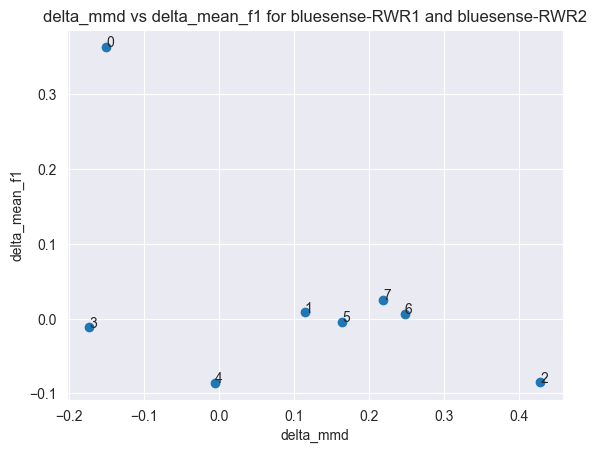

In [22]:
generate_delta_mmd_graph('bluesense-RWR1', 'bluesense-RWR2')

bluesense-RWR2
bluesense-RWR2


D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\matplotlib\text.py:1463: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\matplotlib\text.py:754: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\matplotlib\text.py:895: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))


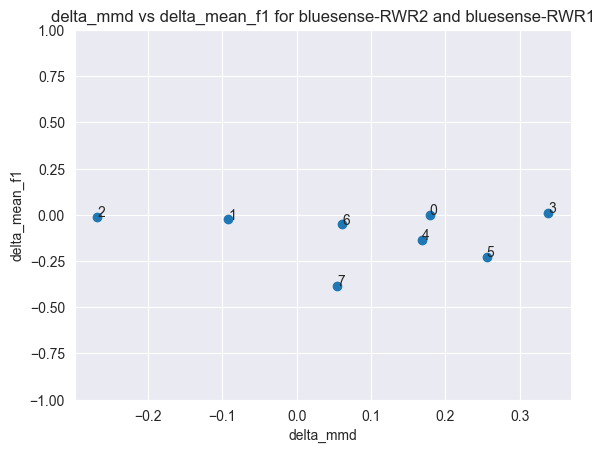

In [16]:
generate_delta_mmd_graph('bluesense-RWR2', 'bluesense-RWR1')

bluesense-LWR
bluesense-LWR


D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\matplotlib\text.py:1463: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\matplotlib\text.py:754: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\matplotlib\text.py:895: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))


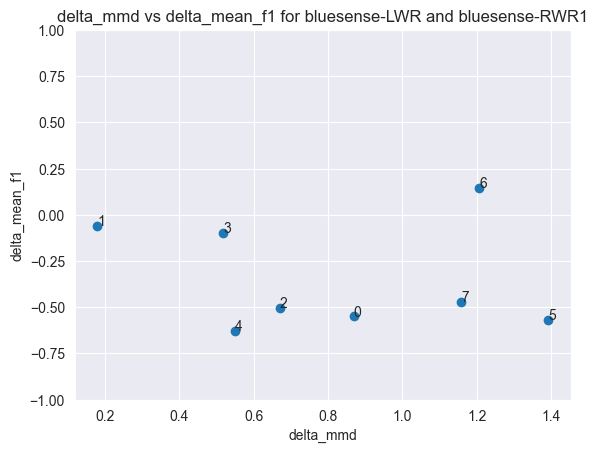

In [17]:
generate_delta_mmd_graph('bluesense-LWR', 'bluesense-RWR1')

bluesense-RWR1
bluesense-RWR1


D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\matplotlib\text.py:1463: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\matplotlib\text.py:754: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\matplotlib\text.py:895: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))


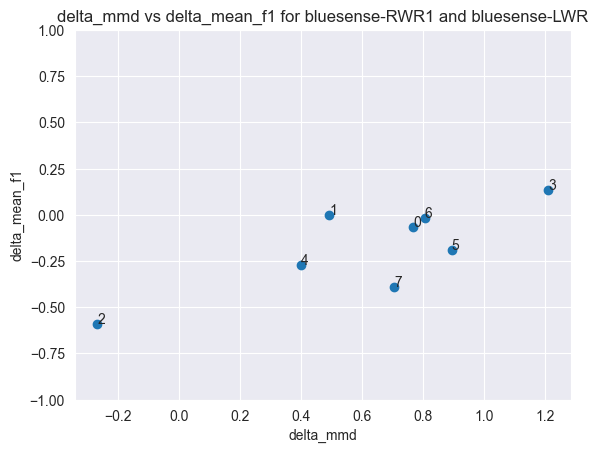

In [18]:
generate_delta_mmd_graph('bluesense-RWR1', 'bluesense-LWR')

empatica-left
empatica-left


D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\matplotlib\text.py:1463: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\matplotlib\text.py:754: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\matplotlib\text.py:895: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))


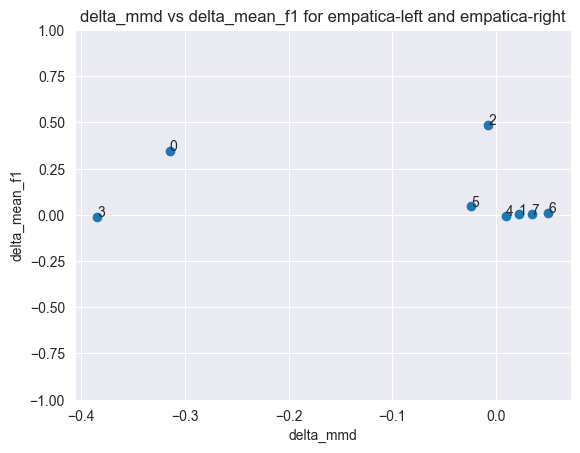

In [19]:
generate_delta_mmd_graph('empatica-left', 'empatica-right')

empatica-right
empatica-right


D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\matplotlib\text.py:1463: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\matplotlib\text.py:754: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\matplotlib\text.py:895: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))


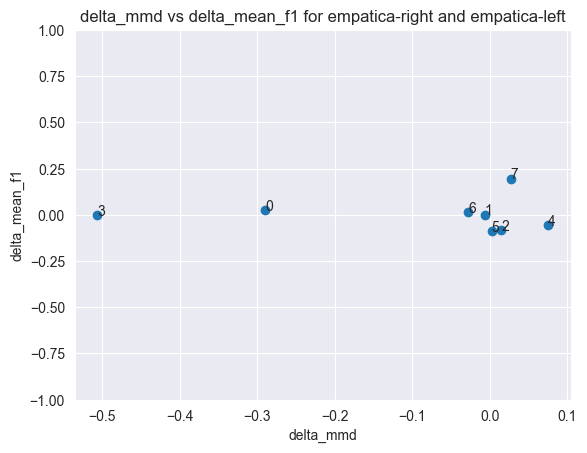

In [20]:
generate_delta_mmd_graph('empatica-right', 'empatica-left')